In [1]:
#TODO
# - fazer analise com funções quadraticas simples
# - fazer analise com funções quadraticas criadas aleatoriamente
#     - criar função para gerar quadraticas convexas e nao convexas aleatoriamente (strongly convex é facil)
# - fazer calculo do gradiente da softmax
# - 

# Bibliotecas a serem usados no projeto

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

# Parte 1: gradiente descendente em funções quadráticas

Ao implementar um algoritmo de descida de gradiente, podemos escolher dentre diversos métodos para escolha do tamanho do passo a ser dado. Aqui, exploraremos dois deles: short-step e busca em linha exata.

## Preparação das funções quadráticas

Sabemos que para funções diferenciáveis, uma possível definição de convexidade forte é se a função pode ser cotada inferiormente por uma quadrática de coefficiente $m>0$. Em outras palavras, temos:

$$f(y) \geq f(x)+\nabla f(x)^T(y-x)+\frac{m}{2}\|y-x\|^2 \hspace{10pt} \forall x,y \in \text{Dom}(f)$$

Além disso, se a função é duplamente continuamente diferenciável - o que seria o caso neste exercício, já que lidamos apenas com quadráticas - uma outra maneira de caracterizar convexidade forte é pela propriedade

$$ \nabla^2 f(x) \succeq mI  \implies Q - mI \succeq 0. $$

Logo, teremos que definir $Q$ de tal modo que possua paenas autovalores positivos para os casos fortemente convexos, e pelo menos um autovalor nulo para o caso convexo. A função não convexa por sua vez possuirá pelo menos um autovalor negativo.

Para o caso apenas convexo, irrmos utilizar uma estratégia diferente para permitir a criação de matrizes automaticamente. Sabemos que podemos decompor uma matriz quadrada em função de seus autovalores e autovetores:

$$ Q = P \Lambda P^{-1} $$

onde $\Lambda$ é uma matriz diagonal de autovalores e $P$ é uma matriz ortogonal cujas colunas são os autovetores associados a cada autovalor. Podemos então partir de uma lista de autovalores e um conjunto qualquer de vetores ortogonais, e chegar a uma matrix qualquer. Abaixo, os vetores ortogonais podem ser gerados aleatoriamente por meio da decomposição QR de uma matriz aleatória. Essa estratégia poderia também ser usada para gerar matrizes aleatoriamente nos casos fortemente convexo e não-convexo, bastando a escolha correta da lista de autovalores.

In [31]:
def QuadraticFunction(x, Q, b, c):
    return x.T @ Q @ x + b.T @ x + c

def QuadraticGradient(x, Q, b):
    return Q @ x + b

def GeneratePSDMatrix(positiveEigValue:int=1):

    # Defining non-negative eigenvalues
    eigenvalues = np.array([positiveEigValue, 0])  
    
    # Generate a set of orthogonal vectors from the columns of an orthogonal matrix
    Q, R = np.linalg.qr(np.random.randn(2, 2), mode='complete') 
    
    # Recreate a matrix from the eigenvalues and orthogonal vectors.
    Q = Q @ np.diag(eigenvalues) @ Q.T
    return Q

def GenerateMatrixFromEigValues(eigValues:np.ndarray):

    # Generate a set of orthogonal vectors from the columns of an orthogonal matrix
    Q, R = np.linalg.qr(np.random.randn(2, 2), mode='complete') 
    
    # Recreate a matrix from the eigenvalues and orthogonal vectors.
    Q = Q @ np.diag(eigValues) @ Q.T
    return Q


## Funções fortemente convexas

Sabemos que para funções fortemente convexas, 

### Número de iterações constantes, variando condicionamento da Hessiana:

In [4]:
samples = 100
conditionNumbers = []
finalGradientNorms = []
finalObjectiveValues = []
iterations = []
maxEigs = []

gradientNormStop = 1e-3
maxSteps = 100
initialPoint = np.array([1,1])
useGradientStop = False

for q11 in range(4, 4+samples):    

    # Preparando função fortemente convexa
    Q = np.array([[q11, 0],[0, 3]])
    # Q = Q.T @ Q
    b = np.array([0,0])
    c = 0
    objective = QuadraticFunction
    objectiveGradient = QuadraticGradient
    
    # Calculando constante de Lipschitz  
    eigValues, eigvectors = np.linalg.eig(Q)
    maxEig = np.max(eigValues)
    minEig = np.min(eigValues)
    stepSize = 1/maxEig

    # Iteração zero do algoritmo
    point = initialPoint
    gradient = objectiveGradient(point, Q, b)
    gradientNorm = np.linalg.norm(gradient)
    objectiveValue = objective(point, Q, b, c)

    iter = 1
    while iter < maxSteps or (gradientNorm > gradientNormStop and useGradientStop):

        point = point - stepSize*gradient
        gradient = objectiveGradient(point, Q, b)
        gradientNorm = np.linalg.norm(gradient)
    
        iter = iter + 1
        
    conditionNumbers.append(maxEig/minEig)
    finalGradientNorms.append(gradientNorm)
    finalObjectiveValues.append(objective(point, Q, b, c))
    iterations.append(iter)
    maxEigs.append(maxEig)

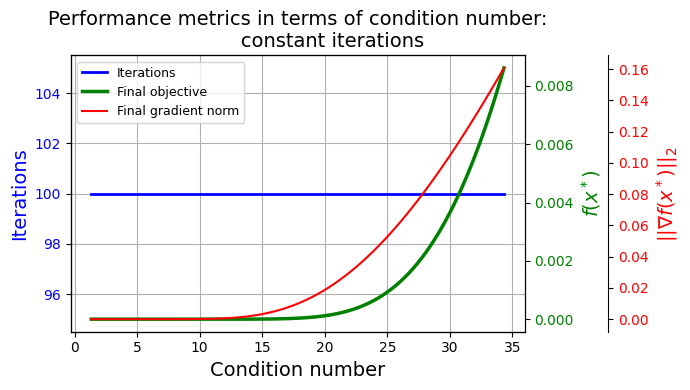

In [5]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot the first curve
ax1.plot(conditionNumbers, iterations, label='Iterations', color='blue', linewidth=2)
ax1.set_xlabel('Condition number', fontsize=14)
ax1.set_ylabel('Iterations', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(conditionNumbers, finalObjectiveValues, label='Final objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(conditionNumbers, finalGradientNorms, label='Final gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of condition number:\n \
          constant iterations', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


Mantendo o número de iterações do algoritmo constante, vemos uma piora crescente na qualidade da solução encontrada. 

### Número de iterações limitado + gradiente mínimo:

In [6]:
samples = 100
conditionNumbers = []
finalGradientNorms = []
finalObjectiveValues = []
iterations = []
maxEigs = []

gradientNormStop = 1e-3
maxSteps = 100
initialPoint = np.array([1,1])
useGradientStop = True

for q11 in range(4, 4+samples):    

    # Preparando função fortemente convexa
    Q = np.array([[q11, 0],[0, 3]])
    b = np.array([0,0])
    c = 0
    objective = QuadraticFunction
    objectiveGradient = QuadraticGradient
    
    # Calculando constante de Lipschitz  
    eigValues, eigvectors = np.linalg.eig(Q)
    maxEig = np.max(eigValues)
    minEig = np.min(eigValues)
    stepSize = 1/maxEig

    # Iteração zero do algoritmo
    point = initialPoint
    gradient = objectiveGradient(point, Q, b)
    gradientNorm = np.linalg.norm(gradient)
    objectiveValue = objective(point, Q, b, c)

    iter = 1
    while iter < maxSteps and (gradientNorm > gradientNormStop and useGradientStop):

        point = point - stepSize*gradient
        gradient = objectiveGradient(point, Q, b)
        gradientNorm = np.linalg.norm(gradient)
    
        iter = iter + 1
        
    conditionNumbers.append(maxEig/minEig)
    finalGradientNorms.append(gradientNorm)
    finalObjectiveValues.append(objective(point, Q, b, c))
    iterations.append(iter)
    maxEigs.append(maxEig)

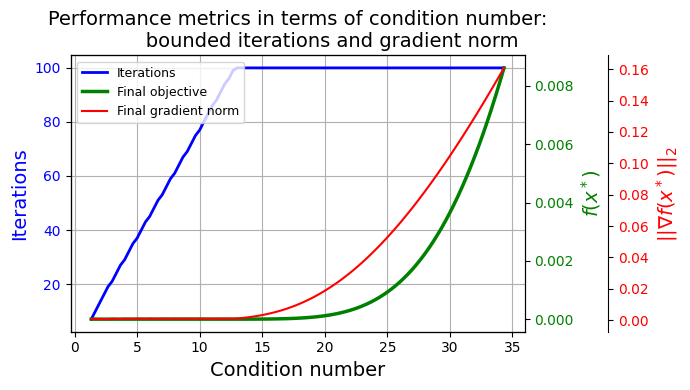

In [7]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot the first curve
ax1.plot(conditionNumbers, iterations, label='Iterations', color='blue', linewidth=2)
ax1.set_xlabel('Condition number', fontsize=14)
ax1.set_ylabel('Iterations', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(conditionNumbers, finalObjectiveValues, label='Final objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(conditionNumbers, finalGradientNorms, label='Final gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of condition number:\n \
          bounded iterations and gradient norm', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


O número de iterações necessárias para se alcançar o valor mínimo pre-estabelecido para o gradiente aumenta linearmente de início, o que é o esperado visto a dependência linear da taxa de convergência em relação ao número de condição da função objetivo. Após o teto de iterações ser alcançado, o crescimento (rápido, porém não exponencial) do mínimo atingido é similar ao gráfico anterior.

## Funções convexas, com ao menos 1 autovalor = 0:

Aqui, o meu método para gerar matrizes aleatórias a partir dos autovalores ocasionalmente gerava Hessianas de funções não-convexas (provavelmente por conta de erros numéricos) e estava obtendo valroes negativos. Optei por utilizar um autovalor apenas próximo a zero em um dos autovalores.

In [77]:
samples = 100
conditionNumbers = []
finalGradientNorms = []
finalObjectiveValues = []
iterations = []
maxEigs = []

gradientNormStop = 1e-3
maxSteps = 3000
# initialPoint = np.random.random_sample(2)
initialPoint = np.array([1,1])
useGradientStop = True

for positiveEigValue in [i for i in range(1, 1+samples)]:    

    # Preparando função fortemente convexa
    Q = GenerateMatrixFromEigValues([positiveEigValue, 0.01])
    b = np.array([0,0])
    c = 0
    objective = QuadraticFunction
    objectiveGradient = QuadraticGradient
    
    # Calculando constante de Lipschitz  
    eigValues, eigvectors = np.linalg.eig(Q)
    maxEig = np.max(eigValues)
    stepSize = 1/maxEig

    # Iteração zero do algoritmo
    point = initialPoint
    gradient = objectiveGradient(point, Q, b)
    gradientNorm = np.linalg.norm(gradient)
    objectiveValue = objective(point, Q, b, c)

    iter = 1
    while iter < maxSteps and (gradientNorm > gradientNormStop and useGradientStop):
        point = point - stepSize*gradient
        gradient = objectiveGradient(point, Q, b)
        gradientNorm = np.linalg.norm(gradient)
    
        iter = iter + 1

    conditionNumbers.append(positiveEigValue)
    finalGradientNorms.append(gradientNorm)
    finalObjectiveValues.append(objective(point, Q, b, c))
    iterations.append(iter)
    maxEigs.append(maxEig)

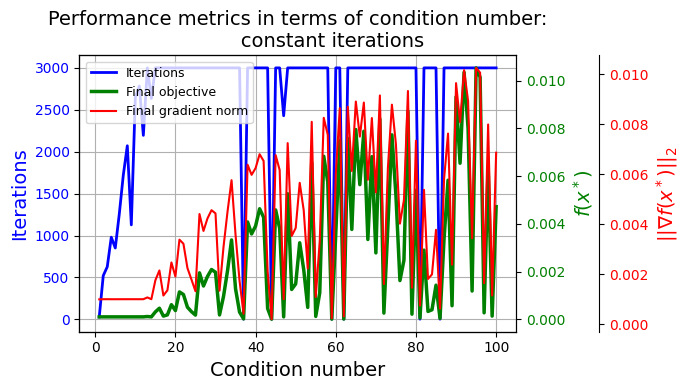

In [ ]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot the first curve
ax1.plot(conditionNumbers, iterations, label='Iterations', color='blue', linewidth=2)
ax1.set_xlabel('Maior autovalor', fontsize=14)
ax1.set_ylabel('Iterations', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(conditionNumbers, finalObjectiveValues, label='Final objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(conditionNumbers, finalGradientNorms, label='Final gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of condition number:\n \
          constant iterations', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

Os resultados nos mostram um comportamento bem instável na busca do ótimo. O número de iterações necessárias para se chegar no gradiente mínimo parece crescer linearmente até o ponto em que o limite máximo de iterações entra em ação. Após isso, a qualidade do resultado piora, mas não exponencialmente como visto no caso fortemente convexo. 

É possível que isso tenha a ver com a escolha do tamanho do passo (o maior autovalor) ? Também não sei explicar o comportamento oscilatório das métricas obtidas em função do maior autovalor. 

### Funções não-convexas:

Nesse caso, vamos apresentar apenas um exemplo de função não-convexa de forma a ilustrar o comportamento esperado de uma algoritmo de descida de gradiente: divergir na direção de um gradiente positivo. 

In [ ]:
gradientNorms = []
objectiveValues = []
iterations = []

gradientNormStop = 1e-3
maxSteps = 100
# initialPoint = np.random.random_sample(2)
initialPoint = np.array([1,1])
useGradientStop = True

# Preparando função fortemente convexa
Q = GenerateMatrixFromEigValues([2, -2])
b = np.array([0,0])
c = 0
objective = QuadraticFunction
objectiveGradient = QuadraticGradient

# Calculando constante de Lipschitz  
eigValues, eigvectors = np.linalg.eig(Q)
maxEig = np.max(eigValues)
stepSize = 1/maxEig

# Iteração zero do algoritmo
point = initialPoint
gradient = objectiveGradient(point, Q, b)
gradientNorm = np.linalg.norm(gradient)
objectiveValue = objective(point, Q, b, c)

def GradientDescent(gradientNorms, objectiveValues, iterations, gradientNormStop, maxSteps, useGradientStop, Q, b, c, objective, objectiveGradient, stepSize, point, gradient, gradientNorm):
    iter = 1
    while iter < maxSteps and (gradientNorm > gradientNormStop and useGradientStop):
        point = point - stepSize*gradient
        gradient = objectiveGradient(point, Q, b)
        gradientNorm = np.linalg.norm(gradient)

        iter = iter + 1

        gradientNorms.append(gradientNorm)
        objectiveValues.append(objective(point, Q, b, c))
        iterations.append(iter)

GradientDescent(gradientNorms, objectiveValues, iterations, gradientNormStop, maxSteps, useGradientStop, Q, b, c, objective, objectiveGradient, stepSize, point, gradient, gradientNorm)


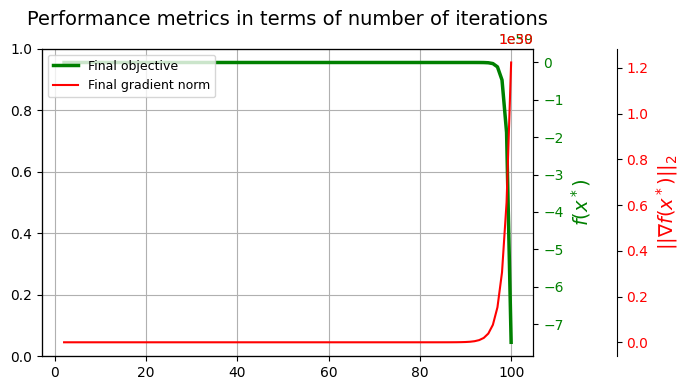

In [44]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(iterations, objectiveValues, label='Final objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(iterations, gradientNorms, label='Final gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of number of iterations', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

Vemos que, após um certo momento, utilizando um passo constante proporcional ao maior autovalor, o algoritmo diverge rapidamente após um certo número de iterações. Essa divergência seria ainda mais pronunciada se usássemos uma estratégia de passo proporcional à norma do gradiente, já que nessa hipótese o tamanho do passo em si também divergiria.

## Plot de exemplos de funções fortemente convexas, convexas e não convexas  

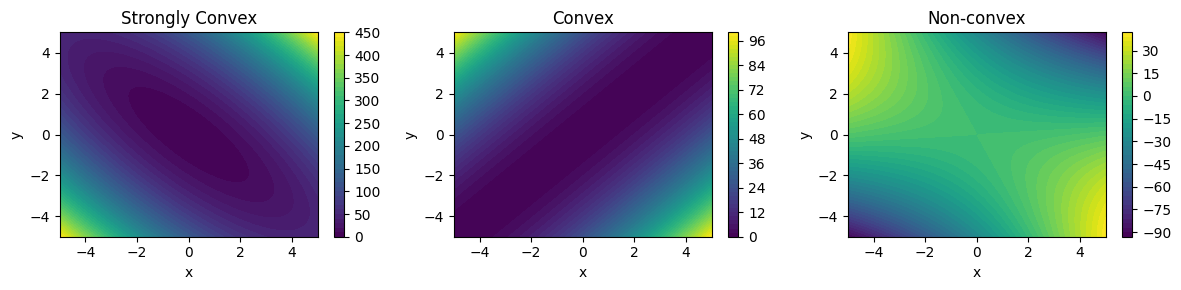

In [ ]:
# Computing each type of quadratic
QStronglyConvex, b1, c1 = np.array([[1,2], [2,1]]), np.array([0,0]), 0
QStronglyConvex = QStronglyConvex @ QStronglyConvex
QConvex, b2, c2 = GeneratePSDMatrix(2), np.array([0,0]), 0
QNonConvex, b3, c3 = GenerateMatrixFromEigValues(np.array([1,-2])), np.array([0,0]), 0

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
grid = np.stack([X.ravel(), Y.ravel()], axis=1)  # Flattened grid for computation

# Compute function values for each quadratic function
Z1 = np.array([QuadraticFunction(pt, QStronglyConvex, b1, c1) for pt in grid]).reshape(X.shape)
Z2 = np.array([QuadraticFunction(pt, QConvex, b2, c2) for pt in grid]).reshape(X.shape)
Z3 = np.array([QuadraticFunction(pt, QNonConvex, b3, c3) for pt in grid]).reshape(X.shape)

# Plot side-by-side contour plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Quadratic Function 1
contour1 = axs[0].contourf(X, Y, Z1, levels=50, cmap="viridis")
axs[0].set_title("Strongly Convex")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
fig.colorbar(contour1, ax=axs[0])

# Quadratic Function 2
contour2 = axs[1].contourf(X, Y, Z2, levels=50, cmap="viridis")
axs[1].set_title("Convex")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
fig.colorbar(contour2, ax=axs[1])

# Quadratic Function 3
contour3 = axs[2].contourf(X, Y, Z3, levels=50, cmap="viridis")
axs[2].set_title("Non-convex")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
fig.colorbar(contour3, ax=axs[2])

plt.tight_layout()
plt.show()

## Gradiente descendente com busca em linha exata

## Gradiente descendente com short-step

# Parte 2: classificação multinomial no dataset MNIST

## Cáculo do gradiente da função objetivo softmax

A função softmax é dada por:

$$ \text{softmax}(x)_i = \gamma_i = \frac{\exp(x_i)}{\sum_{j}\exp(x_j)} $$ 

Derivando em relação à k-ésima componente, temos:
$$ \frac{\partial \gamma_i}{\partial x_j} = \left[ \sum_j \exp(x_j) \right]^{-2} \left[ \frac{\partial}{\partial x_k} \exp(x_i)\sum_j\exp(x_j) - \exp(x_i)\sum_j\frac{\partial}{\partial x_k}\exp(x_j) \right] $$

Usando agora o fato de que $ \frac{\partial}{x_i}\exp(x_j) = \delta_{ij}\exp(x_i)$, obtemos:

$$ \frac{\partial \gamma_i}{\partial x_j} = \left[ \sum_j \exp(x_j) \right]^{-2} \left[ \sum_j\delta_{ki}\exp(x_k)\exp(x_j) - \exp(x_i)\delta_{jk}\exp(x_k) \right] $$
$$ = \frac{\delta_{ki}\exp(x_k)}{\sum_j\exp(x_j)} - \frac{\exp(x_i\exp(x_k))}{\left[ \sum_j\exp(x_j) \right]} = \delta_{ki}\gamma_k - \gamma_i\gamma_k = \gamma_i(\delta_{ki}-\gamma_k)$$

É importante notear que usualmente a função custo para a regressão logística multinomial é a entropia cruzada da função softmax. nesse caso, podemos usar a regra da cadeia para obter o gradiente que será efetivamente usado no algoritmo. Sabendo que a entropia cruzada é dada por $ -\sum_i y_i\log(\gamma_i) $, e devemos considerar que na notação utilizada aqui, nossa variável é na verdade os componentes dos vetores de separação das classes ($x_i \rightarrow w_i^{T}x$, sendo $x$ o vetor de features de treino e $w$ os parâmetros do classificador). Temos então no final:

$$ \frac{\partial L}{\partial w_k} = \sum_i \frac{\partial L}{\partial \gamma_i} \frac{\partial \gamma_i}{\partial x} \frac{\partial x}{\partial w_k} = x(\delta(y=k)-\gamma_k).$$ 


De forma mais explícita, as expressões podem ser escritas como:

$$ L(w) = -\left[ \sum_{i=1}^{m}\sum_{k=1}^{K} \delta(y_i=k) \log \left( \frac{\exp ({w_k}^Tx^i)}{\sum_{j=1}^{K}\exp({w_j}^Tx^i)} \right) \right], $$

$$ \nabla_{w^k}L(w) = -\sum_{i=1}^{m} \left[ x^i \left(\delta (y_i=k) - \frac{\exp ({w_k}^Tx^i)}{\sum_{j=1}^{K}\exp({w_j}^Tx^i)} \right) \right] $$ 

onde $K$ denota o número de classificações possíveis, e $m$ o total de dados de treino.

## Carregando base de dados MNIST e preparando conjuntos de treino/teste

In [87]:
# Carregando dados 
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()


# Convertendo matrizes de pixels em uma lista 
x_train = np.array([array.reshape(-1) for array in x_train])
x_test = np.array([array.reshape(-1) for array in x_test])


# One-hot enconding para a classificação de cada dado
y_train = np.eye(10, dtype=int)[y_train]
y_test = np.eye(10, dtype=int)[y_test]


# Normalização dos dados de clareza dos pixels para o intervalo [0,1]
x_train, x_test = (x_train) / 255, (x_test) / 255

In [88]:
# Checando formato dos dados
print(x_train.shape)
print(y_train.shape)

(60000, 784)
(60000, 10)


In [89]:
# Definindo funções custo e gradiente para o problema de classificação multinomial

def Softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True)) 
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def LossFunction(x, y):
    # Para a otmização em si, usaremos a média da loss function para cada classe do problema
    s = Softmax(x)
    return -np.sum(y * np.log(s)) / x.shape[0]  

def Gradient(x, wTx, y):
    s = Softmax(wTx)
    return (x.T @ (s - y)) / x.shape[0]


# Funções para avaliação de performance
def ComputePrediction(x, w):
    probabilities = Softmax(x @ w)
    return np.argmax(probabilities, axis=1) 

def ComputeAccuracy(predictions, labels):
    return np.mean(predictions == labels) * 100

In [99]:
# Dimensões relevantes
K = y_train.shape[1]
n = x_train.shape[1]

# Parâmetros da descida de gradiente. 
gradientNormStop = 1e-3
maxSteps = 1000
learningRate = 0.1
stochasticity = 0.0

conditionNumbers = []
gradientNorms = []
objectiveValues = []
iterations = []
maxEigs = []

objective = LossFunction
objectiveGradient = Gradient

iter = 1
gradientNorm = np.inf
w = np.random.random_sample((n, K))

while iter < maxSteps and gradientNorm > gradientNormStop:

    wTx = x_train @ w
    grad = objectiveGradient(x_train, wTx, y_train)
    gradientNorm = np.linalg.norm(grad)
    w -= learningRate * (grad + stochasticity * gradientNorm * np.random.random_sample(grad.shape))  # Update weights
    loss = objective(wTx, y_train)
    if iter%100 == 0:
        print(f"At iteration {iter}: objective = {loss:.4f}, gradient norm = {gradientNorm:.4f}")
    iter += 1
    
    gradientNorms.append(gradientNorm)
    objectiveValues.append(loss)
    iterations.append(iter)


At iteration 50: objective = 1.2120, gradient norm = 0.3699
At iteration 100: objective = 0.8431, gradient norm = 0.1991
At iteration 150: objective = 0.7050, gradient norm = 0.1387
At iteration 200: objective = 0.6303, gradient norm = 0.1077
At iteration 250: objective = 0.5824, gradient norm = 0.0889
At iteration 300: objective = 0.5485, gradient norm = 0.0762
At iteration 350: objective = 0.5229, gradient norm = 0.0671
At iteration 400: objective = 0.5027, gradient norm = 0.0602
At iteration 450: objective = 0.4862, gradient norm = 0.0547
At iteration 500: objective = 0.4725, gradient norm = 0.0503
At iteration 550: objective = 0.4607, gradient norm = 0.0466
At iteration 600: objective = 0.4506, gradient norm = 0.0436
At iteration 650: objective = 0.4416, gradient norm = 0.0409
At iteration 700: objective = 0.4337, gradient norm = 0.0386
At iteration 750: objective = 0.4267, gradient norm = 0.0366
At iteration 800: objective = 0.4203, gradient norm = 0.0348
At iteration 850: objecti

In [100]:
testPredictions = ComputePrediction(x_test, w)
realLabels = np.argmax(y_test, axis=1)  
testAccuracy = ComputeAccuracy(testPredictions, realLabels)

print(f"Test Accuracy: {testAccuracy:.2f}%")

Test Accuracy: 88.70%


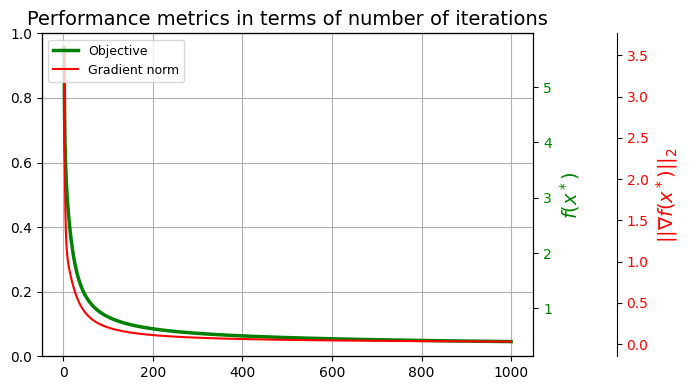

In [ ]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(iterations, objectiveValues, label='Objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(iterations, gradientNorms, label='Gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of number of iterations', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

In [105]:
# Dimensões relevantes
K = y_train.shape[1]
n = x_train.shape[1]

# Parâmetros da descida de gradiente. 
gradientNormStop = 1e-3
maxSteps = 1000
learningRate = 0.1
stochasticity = 0.2

conditionNumbers = []
gradientNorms = []
objectiveValues = []
iterations = []
maxEigs = []

objective = LossFunction
objectiveGradient = Gradient

iter = 1
gradientNorm = np.inf
w = np.random.random_sample((n, K))

while iter < maxSteps and gradientNorm > gradientNormStop:

    wTx = x_train @ w
    grad = objectiveGradient(x_train, wTx, y_train)
    gradientNorm = np.linalg.norm(grad)
    w -= learningRate * (grad + stochasticity * gradientNorm * np.random.random_sample(grad.shape))  # Update weights
    loss = objective(wTx, y_train)
    if iter%100 == 0:
        print(f"At iteration {iter}: objective = {loss:.4f}, gradient norm = {gradientNorm:.4f}")
    iter += 1
    
    gradientNorms.append(gradientNorm)
    objectiveValues.append(loss)
    iterations.append(iter)


At iteration 100: objective = 0.8882, gradient norm = 0.2159
At iteration 200: objective = 0.6446, gradient norm = 0.1138
At iteration 300: objective = 0.5551, gradient norm = 0.0792
At iteration 400: objective = 0.5064, gradient norm = 0.0617
At iteration 500: objective = 0.4753, gradient norm = 0.0513
At iteration 600: objective = 0.4530, gradient norm = 0.0442
At iteration 700: objective = 0.4358, gradient norm = 0.0389
At iteration 800: objective = 0.4223, gradient norm = 0.0349
At iteration 900: objective = 0.4113, gradient norm = 0.0318


In [106]:
testPredictions = ComputePrediction(x_test, w)
realLabels = np.argmax(y_test, axis=1)  
testAccuracy = ComputeAccuracy(testPredictions, realLabels)

print(f"Test Accuracy: {testAccuracy:.2f}%")


Test Accuracy: 88.95%


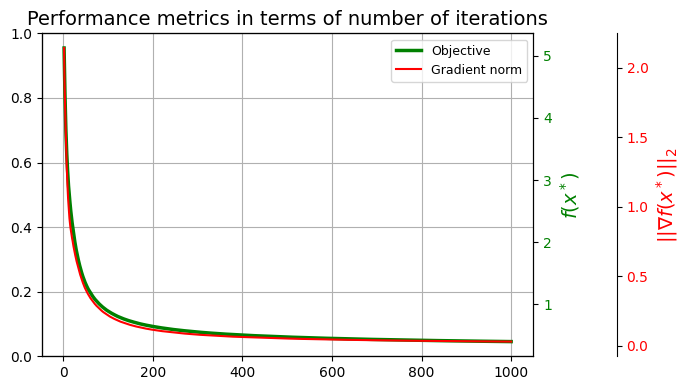

In [107]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(iterations, objectiveValues, label='Objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(iterations, gradientNorms, label='Gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of number of iterations', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()